<a href="https://colab.research.google.com/github/flaviohds/MVP_Machine_Learning/blob/main/MVP_machine_learning2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tempo aproximado de execução do notebook: 5 minutos.

---
---
---


MVP feito para a *sprint* de **Machine Learning & Analytics** do MBA em **Ciencia de Dados e Analytics** pela PUC-rio
*   Autor: **Flávio Horsth De Seta**.
*   Projeto disponível em https://github.com/flaviohds/MVP_Machine_Learning .

Este MVP contém dois projetos indiretamente relacionados.

O primeiro projeto é um problema de previsão de série temporal e será resolvido com modelos clássicos de machine learning. O segundo problema é de processamento de linguagem natural e será resolvido com um modelo de deep learning.

Link para o notebook principal: [parte 1+parte 2](https://colab.research.google.com/drive/1qiKffNoR0W031-O7yry6P6eq3ExayouP?usp=sharing)

In [2]:
# CÉLULA PARA DECIDIR SE O MODELO SERÁ TREINADO OU IMPORTADO

##############################################################
# MUDE "TRAIN_MODEL" PARA 1 CASO DESEJE RETREINAR O MODELO

TRAIN_MODEL = 0

# TEMPO ESTIMADO PARA RETREINAR O MODELO COM 128, 240: 6 HORAS
##############################################################

batch_size = 128
steps = 240

## Preparando o ambiente

In [3]:
# Instalando dependências
! pip install transformers[torch] -q
! pip install datasets -q
! pip install evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.8 MB/s eta 0:00:00


In [46]:
# BIBLIOTECA                                          # FOI UTILIZADO PARA
# bibliotecas da parte 2:
import pandas as pd                                   # manipular dataframes
import matplotlib.pyplot as plt                       # confecção de gráficos
import seaborn as sns                                 # confecção de gráficos
import numpy as np                                    # acessar e funções matemáticas

import gdown                                          # baixar arquivos do google drive
import os                                             # manipular o diretório do ambiente
import zipfile                                        # manipular arquivos compactados
import evaluate                                       # acessar métria de acurácia

from sklearn.metrics import confusion_matrix          # gerar matriz de confusão
from sklearn.metrics import classification_report     # gerar métricas de classificação
from collections import Counter                       # contar valores numa lista
from datasets import load_dataset, Dataset            # classe de dataset do HuggingFace
from transformers import AutoModelForSequenceClassification, AutoTokenizer # modelo e tokenizador do HuggingFace
from transformers import Trainer, TrainingArguments   # treinador e argumentos do HuggingFace

In [5]:
sns.set_theme()                                       # estilizar os gráficos
seed = 33                                             # reprodutibilidade do notebook
np.random.seed(seed)                                  # reprodutibilidade do notebook
pd.set_option('display.precision', 3)                 # facilidade de leitura do dataframe

---
# <center> Parte 2: Processamento de linguagem natural com Deep Learning
---

## 2.1 Introdução

Em um mundo cada vez mais digital, a quantidade de dados gerado e o interesse de empresas nesses dados cresce exponencialmente. Considerando essa constante mudança, é natural as empresas não terem capacidade de analisar e realizar previsões bem fundamentadas, pelo menos não tão rápido quanto elas gostariam. É nessa necessidade que se encaixa o machine learning.

Em problemas comuns com dados estruturados o machine learning clássico é capaz de realizar previsões muito boas. Porém, em problemas com dados não estruturados e matematicamente complexos, uma regressão linear ou árvore de decisão simples não é capaz de obter resultados satisfatórios. O problema de processamento de linguagem natural (NLP) é um desses casos em que os algoritmos de machine learning clássico têm dificuldade. Com o avanço da área de redes neurais, nascem os algoritmos de deep learning, que se mostram cada vez mais capazes de tratar de problemas de NLP. Porém, esse tipo de algoritmo apresenta um grande problema. Frente à complexidade do algoritmo e seu grande número de variáveis a serem ajustadas, é necessária uma grande quantidade de dados.

O problema em si não é a quantidade de dados, já que o mundo digital gera mais dados do que se é capaz de armazenar, mas sim a necessidade de rotular esses dados. Considerando o volume de dados necessário para o treinamento de uma rede de deep learning, a tarefar de rotular milhares de frases passa a ser muito custosa. Surge então a ideia de reduzir este problema utilizando dados rotulados pelos próprios usuários em reviews de produtos para treinamento.

---

## 2.2 Descrição do problema

Este MVP utilizará uma base de reviews de produtos para treinar um modelo que seja capaz de prever a nota dada para o produto baseado no texto do review. Além disso, no final do projeto este modelo será testado para dar uma nota para tweets simulados que falem sobre o desempenho dos produtos e satisfação do consumidor. Ou seja, o objetivo do projeto é realizar um breve estudo da capacidade de transferência de tarefa de prever notas de um review para análise de sentimento de tweets, desde que dentro do mesmo escopo de satisfação de um cliente com um produto. A ideia é apresentar uma possível solução para o problema de falta de rótulos enfrentado por empresas de varejo ao monitorar reações do público em redes sociais.

O modelo não será treinado do zero. Considerando a quantidade de dados necessária para um modelo de NLP aprender a relação de cada palavra existente em uma língua, foi escolhido pegar o modelo base do [Google BERT](https://huggingface.co/bert-base-cased). Porém, será realizado um treinamento de fine-tuning em cima do dataset de reviews. Toda a vez que for mencionado "treinamento" ou "treino" neste notebook, estará se referindo ao treinamento de fine-tunning que será realizado na seção 2.5, enquanto o treinamento do zero (feito pelo grupo google, [que utilizou mais de 800 milhões de palavras](https://www.analyticssteps.com/blogs/history-importance-and-use-cases-bert-model#:~:text=The%20first%20version%20of%20the,of%20these%20models%20are%20enormous!)) do BERT será referido como pré-treinamento.

O [dataset utilizado](https://huggingface.co/datasets/amazon_reviews_multi) contém informações sobre reviews de produtos da amazon. Os reviews se apresentam em 6 possíveis línguas e 31 possíveis categorias de produto. Afim de relacionar as duas partes do MVP, o dataset será filtrado apenas para reviews na língua inglesa e de categorias parecidas com as presentes na primeira parte.

Os atributos do dataset são:

- **review_id**: identificador do review (string)
- **product_id**: identificador do produto (string)
- **reviewer_id**: identificador do consumidor (string)
- **stars**: nota dada pelo consumidor para o produto (inteiro, discreto, 1-5)
- **review_body**: o corpo do review (string)
- **review_title**: o título do review (string)
- **language**: sigla da língua em que o review se encontra (string)
- **product_category**: categoria do produto do review (string)

---

## 2.3 Filtragem prévia do dataset e breve análise dos dados

O [dataset](https://huggingface.co/datasets/amazon_reviews_multi) foi carregado e filtrado em um [notebook separado](https://colab.research.google.com/drive/1vJ9PfVA9-vChhwNRTBpqmyQU0SCnlWIZ?usp=sharing), afim de reduzir o tempo de execução deste notebook principal. No notebook de filtragem, foram aproveitados apenas os reviews em inglês de produtos que se encaixavam nas categorias vistas no [primeiro MVP](https://colab.research.google.com/drive/18IbiSGZq93gUoOOAWgPGpZfT-E8HHNPz?usp=sharing) e explicitadas na primeira parte deste notebook (eletrônicos, mobília e material de escritório). As categorias do dataset da amazon utilizadas foram: home, wireless, home_improvement, pc, electronics, office_product, furniture, camera, video_games e watch.

Os datasets de treino, validação e teste foram salvos e podem ser encontrados no [github do MVP](https://github.com/flaviohds/MVP_Machine_Learning) com os nomes de NLP_df_train.csv, NLP_df_validation.csv e NLP_df_test.csv, respectivamente.

Começa-se carregando os dados filtrados.

In [6]:
# Os dataframes serão organizados em um dicionário
df_raw = {}

# Carregando os dataframes do github do projeto
base_url = 'https://raw.githubusercontent.com/flaviohds/MVP_Machine_Learning/main/'
df_raw['train'] = pd.read_csv(base_url+'NLP_df_train.csv', index_col=0)
df_raw['validation'] = pd.read_csv(base_url+'NLP_df_validation.csv', index_col=0)
df_raw['test'] = pd.read_csv(base_url+'NLP_df_test.csv', index_col=0)

Agora que carregamos os datasets, podemos começar a verificar a organização dos nossos dados.

In [7]:
# Verificando o número de observações em cada partição
print('observações de treino: ', df_raw['train'].shape[0])
print('observações de validação: ', df_raw['validation'].shape[0])
print('observações de teste: ', df_raw['test'].shape[0])

observações de treino:  65299
observações de validação:  1560
observações de teste:  1603


Nota-se um número muito grande de reviews no dataset de treino. Provavelmente não será possível utilizar todo o dataset no treinamento.

Será interessante ver o dataframe de treino como um todo e verificar se temos linhas duplicadas ou valores nulos.

In [8]:
df_raw['train']

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,en_0964290,product_en_0740675,reviewer_en_0342986,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en,furniture
1,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing...,Not use able,en,home_improvement
2,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and ...,The product is junk.,en,home
3,en_0044972,product_en_0444063,reviewer_en_0656967,1,This product is a piece of shit. Do not buy. D...,Fucking waste of money,en,wireless
4,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct ...,bubble,en,pc
...,...,...,...,...,...,...,...,...
65294,en_0689115,product_en_0879422,reviewer_en_0482175,5,I loved this doorbell. Worked very well in our...,I loved this doorbell,en,home_improvement
65295,en_0982040,product_en_0640040,reviewer_en_0210391,5,The colors are bright and fits the bed nice,Hi,en,home
65296,en_0297888,product_en_0125756,reviewer_en_0645859,5,Love this! Put this on the wall above my bed a...,Five Stars,en,home
65297,en_0589358,product_en_0402982,reviewer_en_0199163,5,Replaced my battery with it. Works like new.,This works,en,wireless


Temos diversos atributos que seriam úteis em uma análise mais profunda dos dados. Porém, para o objetivo desse projeto, utilizaremos apenas os atributos de corpo do review e o atributo alvo de estrelas dadas pelo usuário.

In [9]:
# Verificando linhas duplicadas
df_raw['train'].duplicated().value_counts()

False    65299
dtype: int64

Nenhuma linha duplicada encontrada.

In [10]:
# Verificando valores nulos e retornando a linha onde se encontram
df_raw['train'][df_raw['train'].isnull().any(axis=1)]

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
1356,en_0584273,product_en_0593276,reviewer_en_0270470,1,I never received your product.,NaN,en,camera
13097,en_0363452,product_en_0991504,reviewer_en_0350541,1,Garbage!!!!!! Do not buy!!!!!! Very bad recept...,NaN,en,electronics
17416,en_0684361,product_en_0827066,reviewer_en_0375788,2,They r nice but they don’t stay in the ears,NaN,en,wireless
23897,en_0342117,product_en_0720417,reviewer_en_0712502,2,Nice modern farmhouse touch to decor. Color is...,NaN,en,furniture
29828,en_0678684,product_en_0531413,reviewer_en_0033052,3,Easy to assemble just be aware that when screw...,NaN,en,furniture
37658,en_0216864,product_en_0116972,reviewer_en_0323091,3,I don't have a review for this product as I ha...,NaN,en,video_games
52642,en_0958193,product_en_0927553,reviewer_en_0358321,5,"Watch band and case works great, mine cracked ...",NaN,en,wireless
52827,en_0523164,product_en_0595195,reviewer_en_0533312,5,It was very nice!! Loving it!,NaN,en,wireless
55867,en_0441023,product_en_0580596,reviewer_en_0108372,5,"My husband love this cover for his ipad,",NaN,en,pc
60003,en_0978799,product_en_0138960,reviewer_en_0354304,5,Very Happy with purchase,NaN,en,wireless


Os únicos valores nulos encontrados foram na coluna de título do review. Como temos muitas observações, seria válido remover essas linhas. Porém, como não utilizaremos esta coluna para treinamento do modelo, podemos ignorar esses valores nulos.

Também é importante conferir se o notebook de filtragem retirou todas as línguas e tipos de produtos indesejados.

In [11]:
df_raw['train'].language.value_counts()

en    65299
Name: language, dtype: int64

In [12]:
df_raw['train'].product_category.value_counts()

home                17679
wireless            15717
home_improvement     7136
pc                   6401
electronics          6186
office_product       5521
furniture            2984
camera               2139
video_games           775
watch                 761
Name: product_category, dtype: int64

Aparentemente, os dados estão de acordo com o esperado.

É importante lembrar que, apesar de o dataset originário estar balanceado, realizamos alguns filtros, o que pode causar desbalanceamento do dataset em relação ao atributo alvo 'stars'.

In [13]:
df_raw['train'].stars.value_counts(sort=False)

1    14418
2    13561
3    12370
4    12117
5    12833
Name: stars, dtype: int64

Temos um leve desbalanceamento. Trataremos isso na próxima seção.

Para finalizar a análise, será interessante verificar o tamanho dos diferentes corpos de review.

In [14]:
# Matriz de partição X número de palavras em cada observação
number_words_matrix = []

for key in df_raw.keys():
  # Guarda o tamanho de cada observação em uma lista e armazena na matriz
  number_words_list = [len(x.split()) for x in df_raw[key].review_body.to_list()]
  number_words_matrix.append(number_words_list)

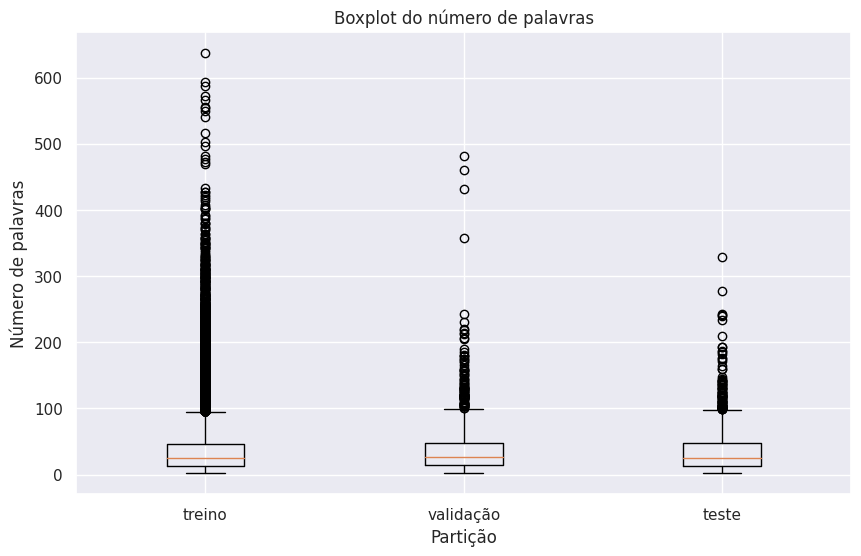

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.boxplot(number_words_matrix)
ax1.set(
        title='Boxplot do número de palavras',
        xlabel='Partição',
        ylabel='Número de palavras',
        )
ax1.set_xticklabels(['treino','validação','teste'])
plt.show()

Nota-se que existe uma grande variação no número de palavras em cada review, variando de menos de 10 até mais de 600. Essa variação pode causar problemas para o modelo, já que ele precisa lidar com vetores de tamanho 'fixo'. Além disso, é fácil de se imaginar que após certo número de palavras, o sentimento expresso por cada frase acaba se repetindo, fazendo com que pouco informação nova seja adicionada por frases no final do review.

---

## 2.4 Pré-processamento

Nesta seção trataremos os dados em relação aos problemas vistos até agora e em especificidades que o modelo utilizado requer.

### Ajuste dos atributos relevantes

Primeiramente, removeremos os atributos que não serão utilizados pelo modelo. Os únicos atributos que necessitamos são o número de estrelas dadas pelo usuário e o texto do review do produto.

Além disso, aproveitaremos para fazer duas mudanças necessárias para o modelo. A primeira é a modificação da nossa variável alvo de 1 a 5, para 0 a 4. A segunda modificação é a alteração dos nomes das colunas para 'text' e 'label'.

Todas essas mudanças serão realizadas nos dataframes de treino, validação e teste.

In [16]:
df = {}
for key in df_raw.keys():
  # É necessário criar uma cópia por conta do funcionamento interno das
  # variáveis no pandas/python. As mudanças serão feitas nessa cópia afim
  # de manter uma versão do dataframe original.
  df[key] = df_raw[key].copy()
  df[key] = df[key].drop(['review_id','product_id','reviewer_id','review_title',
                          'language','product_category'], axis=1)
  df[key].stars.replace({1: 0, 2: 1, 3: 2, 4: 3, 5: 4}, inplace=True)
  df[key].rename(columns={'stars': 'label', 'review_body': 'text'}, inplace=True)

Visualizando o dataframe de treino resultante:

In [17]:
df['train']

,label,text
0,0,Arrived broken. Manufacturer defect. Two of th...
1,0,the cabinet dot were all detached from backing...
2,0,I received my first order of this product and ...
3,0,This product is a piece of shit. Do not buy. D...
4,0,went through 3 in one day doesn't fit correct ...
...,...,...
65294,4,I loved this doorbell. Worked very well in our...
65295,4,The colors are bright and fits the bed nice
65296,4,Love this! Put this on the wall above my bed a...
65297,4,Replaced my battery with it. Works like new.


### Balanceamento

O desbalanceamento visto foi de menos de 13% na pior das classes, o que provavelmente não seria o suficiente para enviesar consideravelmente o treino do modelo. Porém, como temos mais amostras de treino do que será possível utilizar, é interessante balancear as classes. Além disso, balancear os datasets agora é mais simples do que forçar um balanceamento no treino do modelo.

Como não estamos preocupados com perder de algumas amostras, o balanceamento escolhido será feito pela remoção de observações até atingirmos o valor da classe menos representada (no caso do dataset de treino: 4 estrelas, 12117 observações).

In [18]:
# Para garantir a reprodutibilidade da célula
np.random.seed(seed)

df_balanced = {}

# Loop para cada partição. Calcula qual classe é menos representada
for key in df.keys():
  label_count = df[key].label.value_counts(sort=False)
  minimum_count = min(label_count)
  df_balanced[key] = df[key].copy()
  # Loop para cada classe. Calcula número de observações a serem removidas,
  # escolhe os índices e remove do novo dataset.
  for label, count in zip(label_count.index, label_count):
    n_to_remove = count - minimum_count
    df_label = df[key][df[key].label == label]
    indexes_to_remove = np.random.choice(df_label.index, n_to_remove, replace=False)
    df_balanced[key].drop(indexes_to_remove, inplace=True)

  # Reseta o índice e printa os valores das classes do novo dataset
  df_balanced[key].reset_index(drop=True, inplace=True)
  print(key, 'label count:')
  print(df_balanced[key].label.value_counts(sort=False))
  print('')


# # modo alternativo deixado aqui para referência futura
# g = df['train'].groupby('label', group_keys=False)
# g = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)
# g

train label count:
0    12117
1    12117
2    12117
3    12117
4    12117
Name: label, dtype: int64

validation label count:
0    269
1    269
2    269
3    269
4    269
Name: label, dtype: int64

test label count:
0    295
1    295
2    295
3    295
4    295
Name: label, dtype: int64



Agora todos os datasets estão balanceados.

### Amostragem

Como foi mencionado anteriormente, nosso dataset é bem maior do que esperado. Obviamente, seria interessante ter a maior quantidade possível de dados para treinamento e validação, mas, infelizmente, não temos tempo e memória computacional ilimitada.

Como utilizaremos apenas uma época e tamanho de batch limitado, ficaremos limitados ao número de observações de treino $T = batch \times steps$. A vantagem de pegar uma amostragem da partição de treino agora é que conseguimos garantir que o treino visto pelo modelo seja estratificado. Após alguns testes, o treinamento que melhor obteve resultados foi com um batch de 128 e 240 steps, resultando em um total de 30720 observações de treino. Esta decisão de batch e steps é mais discutida na seção de treinamento do modelo.

Em relação ao conjunto de validação, temos um problema similar com o tempo de processamento. Teoricamente, um número muito grande de observações para validação garante que a nossa validação seja heterogênea. Porém, na prática, a validação também aumenta o tempo computacional do treino, já que ela é feita várias vezes, afim de guardar o modelo que obteve maior acurácia ao longo do treino. Também realizaremos uma amostragem estratificada para garantir o balanceamento das classes na validação.

In [19]:
np.random.seed(seed)

df_sample = {}

# Número de observações que serão vistas no treino
T = batch_size*steps

# Pega N amostras de cada classe em cada partição
df_sample['train'] = df_balanced['train'].groupby("label", group_keys=False).apply(lambda x:x.sample(int(T/5)))
df_sample['validation'] = df_balanced['validation'].groupby("label", group_keys=False).apply(lambda x:x.sample(64))
df_sample['test'] = df_balanced['test'].groupby("label", group_keys=False).apply(lambda x:x.sample(100))

print('observações da amostragem de treino: ', df_sample['train'].shape[0])
print('observações da amostragem de validação: ', df_sample['validation'].shape[0])
print('observações da amostragem de teste: ', df_sample['test'].shape[0])

observações da amostragem de treino:  30720
observações da amostragem de validação:  320
observações da amostragem de teste:  500


Verificando se a amostragem de treino tem as classes balanceadas:

In [20]:
df_sample['train']['label'].value_counts()

0    6144
1    6144
2    6144
3    6144
4    6144
Name: label, dtype: int64

### Tokenização

Agora que a maioria das modificações foi feita, podemos começar a passar os dados para o formato pedido pelos modelos do Hugging Face.

In [21]:
dataset = {}

# Instancia os objetos de dataset, requisitados pelos modelos do HuggingFace
for key in df_sample.keys():
  dataset[key] = Dataset.from_pandas(df_sample[key])

dataset

{'train': Dataset({
     features: ['label', 'text', '__index_level_0__'],
     num_rows: 30720
 }),
 'validation': Dataset({
     features: ['label', 'text', '__index_level_0__'],
     num_rows: 320
 }),
 'test': Dataset({
     features: ['label', 'text', '__index_level_0__'],
     num_rows: 500
 })}

Agora, passamos o dataset pelo tokenizador do modelo BERT.

In [22]:
# Carrega do tokenizador do BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Função que tokeniza uma frase
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Aplica a função tokenizadora em cada partição
tokenized_train_dataset = dataset['train'].map(tokenize_function, batched=True)
tokenized_validation_dataset = dataset['validation'].map(tokenize_function, batched=True)
tokenized_test_dataset = dataset['test'].map(tokenize_function, batched=True)

Map:   0%|          | 0/30720 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [23]:
tokenized_train_dataset

Dataset({
    features: ['label', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 30720
})

Nota-se que o tokenizador criou diversos atributos, necessários para o funcionamento de modelos do tipo transformer para NLP.

Um dos atributos importantes para o modelo é o de input_ids. Ele consiste em números correspondentes às palavras do review_body do nosso dataset original. Porém, como o modelo precisa de um número fixo de tamanho de vetor, quando não existem mais palavras para serem transformadas em IDs, o vetor é completado com 0s nas posições restantes. Como o modelo base do BERT consegue lidar com textos grandes, os vetores resultantes acabam por consistir em poucos valores e muitos zeros, como pode ser visto no exemplo abaixo.

In [24]:
i = 0
print('composição do texto tokenizado na posição', i)
print('não-zeros:', np.count_nonzero(tokenized_train_dataset[i]['input_ids']))
print('zeros:', tokenized_train_dataset[i]['input_ids'].count(0))

composição do texto tokenizado na posição 0
não-zeros: 57
zeros: 455


Esses grandes vetores causaram problemas de memória e de tempo computacional em tentativas anteriores de treino. Nota-se que o número máximo de tokens aceito pelo BERT é 512.

A ideia é fazer um truncamento dos vetores para reduzir os recursos computacionais necessários. Para escolher qual o valor mínimo de truncamento, é interessante ver a distribuição do tamanho desses vetores.

In [25]:
datasets = [tokenized_train_dataset, tokenized_validation_dataset, tokenized_test_dataset]
number_ids_matrix = []

# Conta quantos tokens não-zero existem em cada texto de cada dataset
for i_dataset in datasets:
  number_ids_list = []

  input_ids_matrix = i_dataset['input_ids']

  for input_ids_list in input_ids_matrix:
    nonzero_ids = np.count_nonzero(input_ids_list)
    number_ids_list.append(nonzero_ids)

  number_ids_matrix.append(number_ids_list)


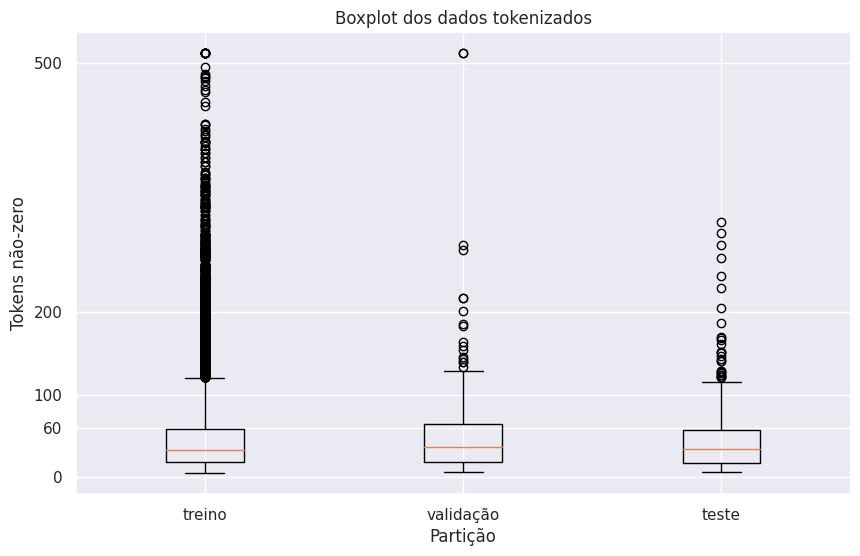

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.boxplot(number_ids_matrix)
ax1.set(
        title='Boxplot dos dados tokenizados',
        xlabel='Partição',
        ylabel='Tokens não-zero',
        )
ax1.set_yticks([0, 60, 100, 200, 500])
ax1.set_xticklabels(['treino','validação','teste'])
plt.show()

Agora que podemos visualizar a distribuição do tamanho do vetor de tokens para cada review, é possível fazer uma escolha coerente. Se escolhermos o valor de 60 para truncamento, manteremos 75% dos reviews intactos. Ao mesmo tempo, é fácil inferir que, em reviews com mais de 60 palavras, o sentimento das diversas frases se repete. Obviamente, mais palavras darão mais confiança para a previsão do modelo, mas temos que considerar o custo e benefício que cada parâmetro terá.

Logo, será refeita a tokenização com o limite máximo de 60 tokens por review.

In [27]:
# Nova tokenização com limite de 60 tokens por frase
def tokenize_function_truncate(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=60)

tokenized_train_dataset = dataset['train'].map(tokenize_function_truncate, batched=True)
tokenized_validation_dataset = dataset['validation'].map(tokenize_function_truncate, batched=True)
tokenized_test_dataset = dataset['test'].map(tokenize_function_truncate, batched=True)

Map:   0%|          | 0/30720 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [28]:
print('nova composição do texto tokenizado na posição', i)
print('não-zeros:', np.count_nonzero(tokenized_train_dataset[i]['input_ids']))
print('zeros:', tokenized_train_dataset[i]['input_ids'].count(0))

nova composição do texto tokenizado na posição 0
não-zeros: 57
zeros: 3


### Demais pré-processamentos

É importante ressaltar o porquê de não termos feito outros pré-processamentos comuns em problemas de NLP. Normalmente, teriam sido considerados os tratamentos de:

- Remoção de stop-words. Seriam retiradas palavras que servem apenas para estruturar uma frase, mas não adicionam contexto ao review. Por exemplo, artigos, pronomes e verbos auxiliares tendem a não alterar a intenção das frases.

- Remoção de caracteres especiais (%, #, =, &, etc.). Caracteres especiais raramente são relevantes e são incomuns o suficiente para o modelo não conseguir aprender nada de útil com eles.

- Lematização. A redução das palavras à sua palavra originária (é → ser) tende a reduzir a quantidade de palavras necessárias a serem aprendidas.

- Remoção de acentos. Apesar de ser incomum na língua inglesa, o ato de colocar ou não colocar um acento erroneamente faz com que o modelo veja aquilo como duas palavras diferentes.

- Expansão de contrações (you've → you have). Muito comum em inglês, as contrações também resultam em mais palavras a serem aprendidas, já que o modelo trata a contração como uma palavra nova.

- Remoção de letras maiúsculas. Outro método de remover diversas apresentações da mesma palavra.

Porém, grande parte desses pré-processamentos já são feitos direta ou indiretamente pelo BERT. O tokenizador, além de transformar as palavras em números, também cria um vetor de atenção que diz quais tokens o modelo deve priorizar. O tokenizador também atribui tokens especiais a caracteres ou palavras que se mostraram pouco relevantes no pré-treinamento. Além disso, em relação aos pré-processamentos que reduziriam a quantidade de palavras a serem aprendidas pelo modelo, esta quantidade passa a ser um problema menor quando foi utilizada uma quantidade absurda de frases como foi feito no pré-processamento do BERT.

Por fim, o BERT é um modelo de transformer bidirecional, ou seja, ele depende das palavras anteriores e posteriores a cada palavra na frase. Considerando que ele realizou um treinamento com 800 milhões de palavras sem os pré-processamentos acima, não é difícil imaginar que [modificar muito o texto original piora a acurácia dos modelos baseados no BERT](https://towardsdatascience.com/does-bert-need-clean-data-part-2-classification-d29adf9f745a). Frente aos fatos citados, foi escolhido não realizar os passos de pré-processamento mencionados acima.

---

## 2.5 Treinamento do modelo

Finalmente podemos começar o treinamento do modelo. Primeiramente, baixamos o modelo BERT pré-treinado para classificações sequenciais e dizemos quantos valores possíveis nosso modelo terá que prever.

In [29]:
np.random.seed(seed)

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Agora, escolhemos os hiperparâmetros do treinamento do modelo.

Como temos muitas observações para treinamento, realizaremos o treino de fine-tunning com uma única época, o que significa que cada review será vista apenas uma vez no treino. Isso praticamente garantirá que não haverá overfitting do modelo, já que ele estará vendo exemplos novos a cada momento de treinamento, resultando em um modelo robusto e com grande capacidade de generalização.

Como utilizaremos o treinamento de época única, temos que dizer para o modelo de quantos em quantos steps ele realizará as tarefas de log, avaliação e salvamento do modelo parcialmente treinado. Foi escolhido 10 steps para a anotação do log e 20 para avaliação e salvamento do modelo, caso este apresente o melhor desempenho até então.



Depois disso, temos que especificar que queremos que, caso a avaliação do modelo no final do treinamento seja menor que a avaliação em um step anterior, a configuração com melhor avaliação deve ser utilizada. Para isso, temos que especificar que a métrica escolhida para esta avaliação é a acurácia e que queremos maximizar esta métrica. Para diminuir a quantidade de arquivos gerados, apenas os dois melhores modelos serão salvos.



Em relação ao learning rate, valores maiores que $10^{-4}$ se mostraram majoritariamente inúteis, já que resultaram em acurácia ao redor da aleatoriedade (20% para o nosso caso de 5 classes). Isso é corroborado pelos autores do BERT, que recomendam learning rate entre $2.10^{-5}$ e $5.10^{-5}$. Valores testados menores que $10^{-6}$ apresentaram estabilidade, mas demoraram muito para apresentar uma acurácia satisfatória, significando que os steps iniciais foram pouco eficientes. O valor de learning rate que apresentou melhor resultado inicial foi o de $3.10^{-5}$. É importante ressaltar que este parâmetro apenas controla o valor inicial do learning rate, já que o método de treinamento utilizado varia seu valor ao longo do treino.



Por fim, temos que escolher os dois parâmetros mais importantes para o desempenho do modelo: tamanho de batch e máximo de steps. O tamanho do batch e os steps foram escolhidos afim de maximizar o número de observações vistas no treino $T = batch \times steps$. Diversas combinações foram testadas para estes parâmetros.

Tamanhos de batch menor do que 16 demoraram bem mais para obter acurácia acima de 50%, mesmo aumentando o número de steps para igualar o $T$. Isso provavelmente se deve ao tamanho do BERT e seu número de pesos. Quanto maior o número de pesos, mais demora a atualização entre os steps. Logo, mesmo que o par 100 steps e batch 2 resulte no mesmo número de observações que 25 steps e batch 8, a segunda configuração acaba por ser mais eficiente em relação ao tempo computacional.

Ao mesmo tempo, batchs muito grandes diminuem as avaliações intermediárias, aumentando as chances de cairmos em um mínimo local. Além disso, somos limitados pela memória máxima que pode ser utilizada pelo colab. Tendo essas consequências e limitações em mente, foram testadas várias configurações e o modelo pareceu continuar aprendendo independentemente dos parâmetros de step e batch, desde que continuássemos fornecendo mais observações para o treinamento dele e seu batch fosse maior que 16. Então, foi tomada a decisão de utilizar o máximo de memória e o máximo de tempo ininterrupto de execução que o colab permitisse.

Após algumas tentativas de treino, chegou-se nos parâmetros que obtiveram o modelo de melhor desempenho. O tamanho de batch máximo que a memória do colab aceitou foi de 128. Com esse tamanho de batch, o número máximo de steps que manteve o tempo estimado de treinamento abaixo de 6 horas (com alguma folga) foi de 240 steps.

Podemos agora instanciar os parâmetros de treino:

In [30]:
MODEL_PATH = "trained_model"

training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    logging_strategy="steps",
    eval_steps=20,
    save_steps=20,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    learning_rate=3e-5,
    max_steps=steps,
    per_device_train_batch_size=batch_size
)

Depois, instanciamos a métrica e a classe de treinador do modelo:

In [31]:
np.random.seed(seed)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

MODEL_PATH = "trained_model"

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    compute_metrics=compute_metrics,
)

Finalmente, podemos realizar o treinamento do modelo. Note que a célula abaixo pode realizar o treinamento do modelo novamente. Porém, como padrão, ela importará o modelo que já foi treinado com os parâmetros citados acima, para diminuir o tempo de execução do notebook.

Caso o leitor deseje realizar o fine-tunning do modelo novamente, basta mudar a variável TRAIN_MODEL (localizada na primeira célula de código do notebook) para o valor 1.

In [32]:
np.random.seed(seed)

# Treina o modelo e cria o log de treinamento. Também salva os dois em arquivos.
if TRAIN_MODEL == 1:
  print('treinando o modelo:')
  trainer.train()

  trainer.save_model(MODEL_PATH)
  tokenizer.save_pretrained(MODEL_PATH)

  df_log = pd.DataFrame(trainer.state.log_history)
  df_log.to_csv('model_training_log.csv', index=False)

  print('')
  print('treinamento finalizado com sucesso!')

# Importa o modelo, tokenizador e o log de treinamento. Também instancia o treinador.
else:
  print('importando o modelo:')
  file_id = "1tgKeK0QfrNsYR2gmTVOMUIW8bSmzpoNb"
  url = f"https://drive.google.com/uc?id={file_id}"

  folder_path = "./download"  # Pasta para onde o arquivo será baixado
  os.makedirs(folder_path, exist_ok=True) # Cria a pasta de destino se necessário

  output = "download/model.zip"  # Especifica o nome do arquivo a descompactar
  gdown.download(url, output)

  with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall()

  model = AutoModelForSequenceClassification.from_pretrained('model')
  tokenizer = AutoTokenizer.from_pretrained('model')

  trainer = Trainer(
                    model=model,
                    args=training_args,
                    train_dataset=tokenized_train_dataset,
                    eval_dataset=tokenized_validation_dataset,
                    compute_metrics=compute_metrics,
                    )

  df_log = pd.read_csv(base_url+'model_training_log.csv')

  print('')
  print('modelo e log de treinamento importados com sucesso!')

importando o modelo:


Downloading...
From: https://drive.google.com/uc?id=1tgKeK0QfrNsYR2gmTVOMUIW8bSmzpoNb
To: /content/download/model.zip
100%|██████████| 402M/402M [00:05<00:00, 71.4MB/s]



modelo e log de treinamento importados com sucesso!


---

## 2.6 Resultados

### Log do treinamento

Agora que temos os dados de treino (seja obtido pelo treinamento, ou importado) podemos plotá-los.

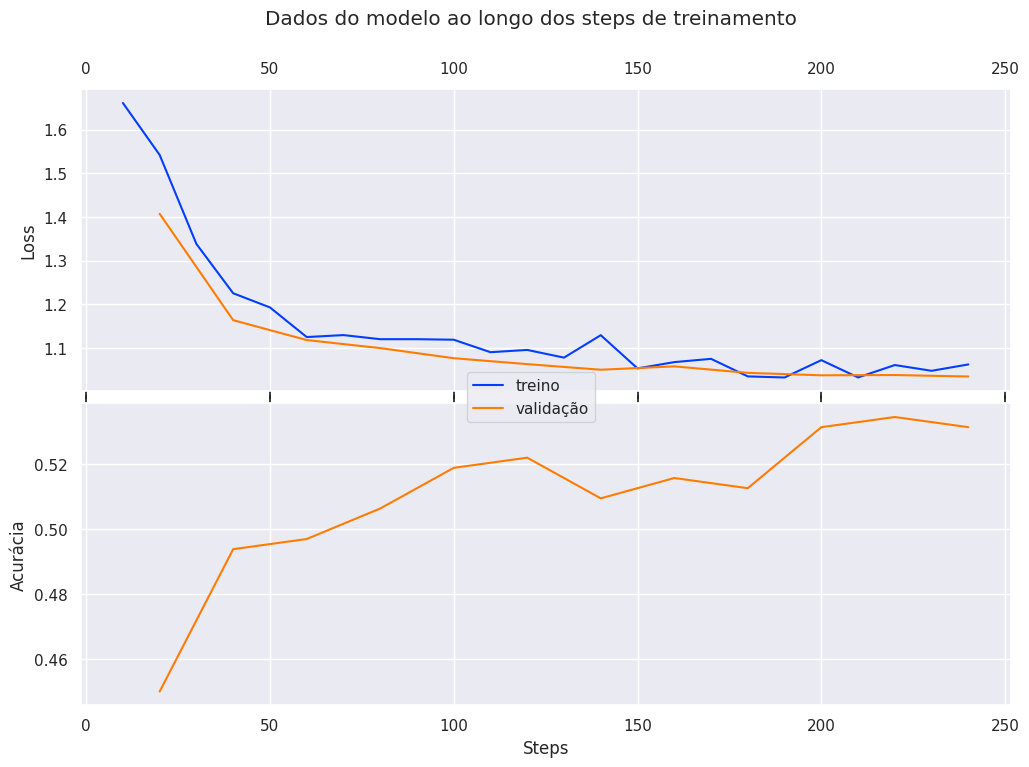

In [33]:
train_steps = df_log.step.dropna().unique()
eval_steps = df_log.step[df_log.step.duplicated()][:-1]

palette = sns.color_palette('bright')
fig,(ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True)
fig.subplots_adjust(hspace=0.04)
fig.suptitle('Dados do modelo ao longo dos steps de treinamento')

ax1.plot(train_steps, df_log.loss.dropna(), color=palette[0], label='treino')
ax1.plot(eval_steps, df_log.eval_loss.dropna(), color=palette[1], label='validação')
ax1.tick_params(top=False, labeltop=True, bottom=True, labelbottom=False)
ax1.set(ylabel='Loss')
handles, labels = ax1.get_legend_handles_labels()

ax2.plot(eval_steps, df_log.eval_accuracy.dropna(), color=palette[1])
ax2.tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
ax2.set(xlabel='Steps', ylabel='Acurácia')

fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.495))

plt.show()

Podemos ver acima a evolução do modelo ao longo do treinamento. No gráfico de Loss, é possível notar que não houve overfitting. Esse fato era esperado porque, como já foi comentado anteriormente, foi utilizado uma única época de treinamento. Isso significa que o modelo viu cada observação apenas uma vez, impossibilitando-o decorar as características dessas observações. Isso resultou em um modelo capaz de generalizar muito bem os conhecimentos obtidos no treino, como pode ser notado pelo fato do loss de treino acompanhar muito de perto o de validação.

No segundo gráfico podemos notar três principais características.

- Foi benéfico escolher muitos steps. O modelo atingiu o mínimo local de aproximadamente 52% de acurácia no step 120, o qual foi seguido de 3 avaliações piores. Se tivéssemos parado no step 180, não obteríamos a melhora que começa a ser observada a partir do step 200. Nota-se também, que houve uma pequena queda no step 240, mas como configuramos para o treinamento para salvar o melhor modelo, esse step será ignorado e o modelo final será o do step 220.

- O modelo foi capaz de entender o problema mesmo com poucas observações. Se observarmos o primeiro ponto, o modelo já tinha obtido uma acurácia de aproximadamente 45%. Essa acurácia pode parecer pior do que um modelo aleatório à primeira vista, mas como nosso problema é uma classificação de 5 classes, a acurácia aleatória é de 20%. Este desempenho mesmo com poucas observações vista no treino se deve a termos escolhido um modelo pre-treinado. Caso tivéssemos escolhido treinar um modelo do zero, ao invés de fazer um fine-tuning, teríamos de esperar milhares de observações de treino até o modelo conseguir se distanciar da aleatoriedade.

- Não parece que a acurácia do modelo irá melhorar significativamente. Até o segundo ponto de validação foram vistas 5120 observações e até o último ponto foram vistas 30720. Entre esses dois pontos, melhoramos a acurácia em apenas 4%. Isto é um indício que estamos nos aproximando da acurácia máxima possível se apenas aumentarmos o número de observações, mesmo que a melhora nos últimos 3 pontos indique que é possível aumentar um pouco mais. Isto é um problema porque nosso modelo está acertando em apenas pouco mais de metade dos casos.



Em relação ao último ponto citado acima, a acurácia relativamente baixa provavelmente se deve a um desafio comum no problema de reviews de usuários. Geralmente, a nossa variável objetivo (label) é algo atribuído por um conselho de especialistas com critérios bem definidos. Não só o nosso label é dado por uma única pessoa, mas é dado por uma pessoa diferente em cada observação. O resultado disso é que a nota dada por dois reviews teóricos idênticos poderia divergir se fosse dada por duas pessoas diferentes. Resumidamente, o label que estamos utilizando pode ser considerado de baixa confiabilidade ou consistência ao longo de todas as observações. Porém, é fácil de imaginar que, independente da pessoa que estiver dando a nota e escrevendo o review, o sentimento de satisfação ou insatisfação é universal. **Logo, espera-se que a inconsistência da nota esteja concentrada nos pares de nota: 0 e 1; 3 e 4.**

Podemos verificar se a afirmação acima é verdadeira observando a matriz de confusão da previsão do modelo em função do label real.

### Teste e matriz de confusão

Primeiro, vamos verificar a acurácia de teste com o critério padrão, onde temos 5 classes diferentes.

In [34]:
# Chama o modelo para criar as previsões em cima da partição de teste
test_model_output = trainer.predict(tokenized_test_dataset)

# Acessa a parte onde as métricas foram armazenadas
test_model_output.metrics

{'test_loss': 1.041521430015564,
 'test_accuracy': 0.538,
 'test_runtime': 131.4767,
 'test_samples_per_second': 3.803,
 'test_steps_per_second': 0.122}

O critério padrão atingiu uma acurácia de 53,8%.



Antes de ver a matriz de confusão, é importante verificar o balanceamento e a tendência do modelo.

In [35]:
# Pega as previsões e valores reais para os labels de teste
test_pred = [np.argmax(x) for x in test_model_output.predictions]
test_real = test_model_output.label_ids

In [36]:
Counter(test_real)

Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100})

Como esperado, a partição de teste está balanceada.

Verificando agora o número de labels previstos:

In [37]:
Counter(test_pred)

Counter({0: 120, 1: 92, 2: 91, 3: 91, 4: 106})

Aqui podemos ver que o modelo tende a prever mais valores extremos (0 e 4) do que valores intermediários (1 a 3), priorizando a nota mínima.

Agora podemos verificar a matriz de confusão. Plotaremos ela normalizada pelo número real do label (linhas) para visualizar melhor para onde o modelo está errando.

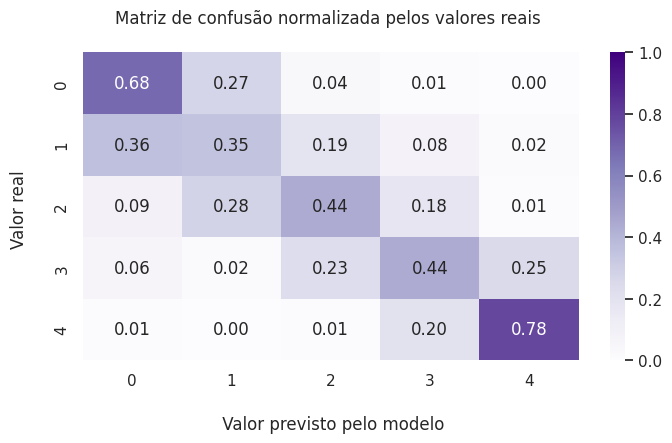

              precision    recall  f1-score   support

           0       0.57      0.68      0.62       100
           1       0.38      0.35      0.36       100
           2       0.48      0.44      0.46       100
           3       0.48      0.44      0.46       100
           4       0.74      0.78      0.76       100

    accuracy                           0.54       500
   macro avg       0.53      0.54      0.53       500
weighted avg       0.53      0.54      0.53       500



In [38]:
# Calcula e plota a matriz de confusão do teste
plt.figure(figsize=(8,4))
fx=sns.heatmap(confusion_matrix(test_real, test_pred, normalize='true'),
               annot=True, fmt=".2f", cmap="Purples", vmin=0, vmax=1)
fx.set_title('Matriz de confusão normalizada pelos valores reais \n')
fx.set_xlabel('\n Valor previsto pelo modelo')
fx.set_ylabel('Valor real \n')
plt.show()

# Calcula e printa as métricas do teste
print(classification_report(test_real, test_pred))

Observando as linhas de valor real 1 e 3 é possível notar um pouco da característica mencionada. Os erros acontecem mais para o lado dos extremos (0 e 4) do que para o lado neutro (2). Este fato é mais evidente no valor real 1, onde o modelo errou mais para a previsão 0 (36%) do que acertou a previsão no próprio valor 1 (35%). É importante ressaltar que este erro (1 para 0), apesar de ser o mais comum, tem pouco impacto na tarefa que será testada na seção seguinte, já que o mais importante é reconhecer se o texto é negativo ou positivo, e não a intensidade do sentimento.

Dito isso, olhando para a terceira linha da matriz, fica claro que o modelo tem dificuldades em reconhecer reviews neutros também. Porém, é interessante notar que não temos muitos erros para dois labels de distância do real. O máximo de erros onde o valor previsto está distante de dois ou mais labels do real é de 10%. Este tipo de erro é o mais impactante em classificações sequenciais, porque estaria classificando um texto positivo com um negativo, ou até mesmo um texto neutro como muito negativo.

Como última observação, podemos notar também que o modelo tem maior facilidade de classificar corretamente sentimentos extremos (0 e 4), como pode ser visto na coluna de precisão. A mesma coluna também mostra que, apesar do modelo tender a classificar textos como 0, ele é melhor em classificar corretamente textos positivos.


Agora que conhecemos melhor o comportamento e limitações do nosso modelo, podemos verificar como ele se comporta diante de uma tarefa similar.

### Tweets simulados

Primeiramente, temos que escolher quais serão nossos textos de teste. O ideal seria ter centenas de exemplos em um dataset balanceado. Porém, como não foi encontrado um dataset desses que falasse sobre as categorias de produtos e usasse uma linguagem parecida com a utilizada no treino, serão simulados alguns tweets aqui.

A ideia é criar textos mais próximos de tweets do que reviews, mas sem utilizar abreviações ou gírias. Ao mesmo tempo, os tweets tem de ter a mesma língua utilizada e falar dos mesmos tipos de produtos que foram utilizados no treinamento (eletrônicos, mobília e material de escritório).

In [39]:
# Cria o vetor de tweets simulados
simulated_tweets=[
    "Bought a chair online and it arrived a week late",
    "Just installed my new RTX. PC is flying",
    "Just installed my new RTX. PC is FLYING",
    "No idea why everyone is complaining about Watch_Dogs, game runs just fine on my PS4",
    "Bought a cabinet that had the wrong dimensions listed... but it actually fits in my living room",
    "I can't work because the monitor I ordered doesn't come with a cable",
    "Just missed a meeting because my new laptop decided it needed to update windows",
    "Can't believe someone could fuck up the packing this badly",
    "Can't believe I lived for 30 years without a universal remote. Just spent the whole Sunday laying on my couch",
    "My new table came with a huge scratch. I can't have my friends come over like this",
    "The new apple watch looks weird",
    "My house looks weird with the new lighting",
    "My house looks awesome with the new lighting"]

Agora que criamos os textos dos tweets, temos que utilizar o mesmo tokenizador do modelo.

In [40]:
tokenized_tweets = [tokenizer(x, return_tensors="pt") for x in simulated_tweets]

Depois, passamos os tweets tokenizados pelo modelo e tratamos a saída para obter o label previsto e as probabilidades de cada label segundo o modelo.

In [41]:
def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

# argmax pega o maior valor de saída e softmax transforma as saídas em probabilidades
pred_label_tweets = [np.argmax(model(**x).logits.detach().numpy()) for x in tokenized_tweets]
prob_label_tweets = [softmax(model(**x).logits.detach().numpy()) for x in tokenized_tweets]

In [42]:
prob_labels_tweets = [x.tolist() for x in prob_label_tweets]

In [43]:
# Um vetor de probabilidade para cada classe
label_prob_0 = []
label_prob_1 = []
label_prob_2 = []
label_prob_3 = []
label_prob_4 = []
for probs in prob_labels_tweets:
  label_prob_0.append(probs[0][0])
  label_prob_1.append(probs[0][1])
  label_prob_2.append(probs[0][2])
  label_prob_3.append(probs[0][3])
  label_prob_4.append(probs[0][4])

Por fim, agrupa-se os tweets, previsão e probabilidades em um dataframe para melhor visualização.

In [44]:
data = list(zip(simulated_tweets, pred_label_tweets, label_prob_0, label_prob_1, label_prob_2, label_prob_3, label_prob_4))
df_tweets = pd.DataFrame(data, columns=['tweet', 'predicted', 'prob0', 'prob1', 'prob2', 'prob3', 'prob4'])
df_tweets

,tweet,predicted,prob0,prob1,prob2,prob3,prob4
0,Bought a chair online and it arrived a week late,0,0.815,0.118,0.047,0.012,0.009
1,Just installed my new RTX. PC is flying,4,0.013,0.011,0.030,0.190,0.755
2,Just installed my new RTX. PC is FLYING,4,0.060,0.025,0.055,0.189,0.671
3,No idea why everyone is complaining about Watc...,3,0.013,0.030,0.100,0.432,0.425
4,Bought a cabinet that had the wrong dimensions...,3,0.006,0.019,0.069,0.467,0.439
5,I can't work because the monitor I ordered doe...,0,0.701,0.207,0.074,0.012,0.006
6,Just missed a meeting because my new laptop de...,2,0.270,0.245,0.317,0.123,0.045
7,Can't believe someone could fuck up the packin...,0,0.476,0.206,0.169,0.082,0.067
8,Can't believe I lived for 30 years without a u...,0,0.602,0.132,0.092,0.067,0.107
9,My new table came with a huge scratch. I can't...,0,0.581,0.207,0.134,0.045,0.033


Dos 12 tweets criados, a maior parte foi prevista satisfatoriamente. As grandes exceções foram:

- 'Just missed a meeting because my new laptop decided it needed to update windows' - A nota prevista pelo modelo foi nota 2, que deveria indicar indiferença, quando claramente este existe um sentimento negativo no texto. Mesmo que a decisão final tenha sido incorreta, é interessante notar que as probabilidades de nota 0 e 1 estão bem próximas da probabilidade da nota 2, indicando que o modelo suspeitava que fosse um tweet negativo.

- 'Can't belive I lived for 30 years without a universal remote. Just spent the whole sunday laying on my couch' - Claramente este é um tweet positivo sobre ter gostado do produto novo, mas o modelo atribuiu um sentimento muito negativo (nota 0) a ele. Além disso, ele deu probabilidade muito baixa do texto ser positivo ou muito positivo.

Todos os outros tweets foram classificados "corretamente", mesmo que alguns sejam discutíveis. É possível notar mais alguns pontos sobre as classificações acima:

- Observando os tweets de índice 1 e 2, parece que o modelo penaliza a capitalização de palavras. Apesar de os dois tweets terem sido classificados como muito positivo, ao olhar a probabilidade do label 4, a capitalização da palavra 'flying' parece ter levado o modelo levemente para o lado negativo. Isso é interessante porque é fácil notar que, nesse caso, a capitalização indica animação do consumidor, o que deveria levar o sentimento mais para o lado positivo. É provável que isso tenha ocorrido porque o modelo viu mais capitalizações em reviews negativos do que positivos no treinamento.

- Esperava-se que os tweets de índice 3 e 4 fossem difíceis para o modelo, já que eles possuem linguagem um pouco conflitante, mas o label previsto foi aceitável. Em "***No idea why everyone is complaining about Watch_Dogs, game runs just fine on my PS4***", a frase possui as palavras 'complaining' e 'just fine' o que geralmente indicaria indiferença ou até negatividade, mas o modelo atribui corretamente uma nota 3. Em "***Bought a cabinet that had the wrong dimensions listed... but it actually fits in my living room***" temos as palavras 'wrong dimensions' o que provavelmente foi visto nos reviews de treino como algo negativo, mas parece que a frase seguinte ser iniciada por 'but' e ter 'fits' foi o suficiente para o modelo indicar um sentimento positivo para este tweet.

- Os três últimos tweets mostram claramente o poder de mudar uma única palavra. Nos dois primeiros podemos ver que a palavra 'weird' faz o modelo tender (corretamente) ao aumento das probabilidades de sentimento neutro ou negativo. Já no último tweet, vemos que ao mudar uma única palavra a probabilidade de sentimento positivo aumenta drasticamente.

No final, pode-se dizer que a transferência de tarefa foi um sucesso, ao menos no nosso teste limitado. Dos 13 exemplos de tweets simulados, o modelo foi capaz de fazer previsões satisfatórias em 11 deles.

In [45]:
# # Código para buscar por palavras nos reviews utilizados para
# # treinamento do modelo. Deixado aqui para conveniência do leitor.

# word_to_search = 'RTX'

# for i in df_sample['train'][df_sample['train']['text'].str.contains(word_to_search)].index:
#   print(df_sample['train']['label'][i], ':', df_sample['train']['text'][i])

---

## 2.7 O que mais poderia ser feito

Frente à acurácia de 53,8% na tarefa de reviews e os testes muito limitados na tarefa de tweets, é interessante listar aqui algumas melhorias que poderiam ser feitas nesta parte do MVP, mas foram deixadas de fora por falta de tempo:

- Aplicar os pré-processamentos citados no final da seção 2.4 para estudar seus efeitos na acurácia do BERT nas duas tarefas.

- Treinar o modelo por mais steps ou com maior tamanho de batch. Foi utilizado quase todo o limite do Google Colab, mas o log de treinamento parece indicar que ainda é possível aumentar um pouco mais a acurácia na tarefa de reviews. Seria interessante utilizar outra plataforma para fornecer mais observações para o treino, já que utilizamos menos de 50% do nosso dataset de treino.

- Aumentar o número de tweets simulados. Fica claro ao observar o nosso limitado número de tweets, que não temos um teste heterogêneo. Seria interessante aumentar o número de tweets simulados, com o intuito de melhorar a confiabilidade do teste.

- Buscar um dataset de tweets que esteja dentro das limitações citadas. Ainda afim de aumentar a confiabilidade do teste da segunda tarefa, seria interessante utilizar um dataset extenso de tweets sobre produtos que não utilizasse abreviações e tags. Também seria possível realizar alguns pré-processamentos em tweets reais para remover essas limitações do dataset.

---

## 2.8 Conclusão

Nesta segunda parte do MVP, foi realizado um fine-tunning do modelo pré-treinado [BERT-base-cased](https://huggingface.co/bert-base-cased) para prever notas de reviews de consumidores em lojas de varejo. Com o modelo treinado, foi avaliada sua capacidade de prever se um tweet tem sentimento positivo ou negativo. Apesar de ter sido testado em tweets simulados, com quantidade reduzida e linguagem controlada, o modelo se mostrou capaz de realizar uma tarefa para a qual não foi diretamente treinada.

O modelo foi treinado observando os textos de reviews da amazon e tentava prever a nota dada pelo usuário, que variava de 1 a 5. O treinamento do modelo utilizou uma única época com 30720 observações, tamanho de batch de 128 e 240 steps. Após o treinamento, o modelo obteve uma acurácia de 53,8% no dataset de teste, considerando as 5 classes distintas.

No final, o modelo foi testado em 13 tweets simulados, que foram criados segundo os seguintes critérios:

- O tweet deve expressar uma opinião sobre um produto de categoria vista no treinamento.

- Apesar de permitir linguagem coloquial, o tweet não pode conter abreviações, tags e links, já que estes não foram vistas no treinamento.

- Não deve haver erros graves de inglês no tweet.

Com as limitações citadas acima, o modelo previu corretamente 11 dos 13 tweets simulados, mesmo que algumas das notas sejam discutíveis. Este resultado mostra que o modelo em questão foi capaz de realizar uma tarefa similar a do treinamento, desde que em um ambiente controlado.



---

---

# falta

aumentar número de tweets

realizar preprocessamentos e testar modelo?




